# Load packages

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
            
from scipy import optimize
from scipy.optimize import minimize
from scipy.stats import gumbel_r
from matplotlib.pyplot import cm
import math
import matplotlib
import matplotlib.colors as mcolors
from scipy.optimize import fsolve

%matplotlib inline
import warnings
from scipy.stats import pearsonr
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import random

import matplotlib.pyplot as plt 
import toml
import pandas as pd
import xarray as xr

colors = ['#0098FA', '#0167A9', '#002C48'] # blauw blauw blauw


# Load data observed

In [2]:
df_meuse = pd.read_excel("1_Data/Stations_Meuse.xlsx")
meuse_names = df_meuse["Read"]

df_meuse_be = pd.read_excel("1_Data/Stations_Meuse_be.xlsx")
meuse_names_be = df_meuse_be["Read"]

In [3]:
for i in range(len(df_meuse)):
    w_flow = df_meuse.loc[i]["Wflow_ID"]
    series = pd.read_csv("1_Data/final/"+str(w_flow)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    series.to_csv("1_Data/final_names/"+str(df_meuse.loc[i]["Read"].strip())+str(".csv"))

#### Dictorionairies

In [4]:
fr_dict = dict([
    ("La Meuse à Goncourt", "La Meuse Goncourt"),
    ("Le Mouzon à Circourt-sur-Mouzon [Villars]", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("Le Vair à Soulosse-sous-Saint-Élophe", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("La Meuse à Saint-Mihiel", "La Meuse Saint-Mihiel"),
    ("La Meuse à Stenay", "La Meuse Stenay"),
    ("La Chiers à Longlaville", "La Chiers Longlaville"),
    ("La Crusnes à Pierrepont", "La Crusnes Pierrepont"),
    ("Le Ton à Écouviez", "Le Ton Écouviez"),
    ("Le Loison à Han-lès-Juvigny", "Le Loison Han-lés-Juvigny"),
    ("La Chiers à Carignan", "La Chiers Carignan"),
    ("La Bar à Cheveuges", "La Bar Cheveuges"),
    ("La Vence à la Francheville", "La Vence la Francheville"),
    ("La Sormonne à Belval", "La Sormonne Belval"),
    ("La Meuse à Chooz", "Chooz"),
])

fr_dict_inv = dict([
    ("La Meuse Goncourt", "La Meuse à Goncourt"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "Le Mouzon à Circourt-sur-Mouzon [Villars]",),
    ("Le Vair Soulosse-sous-Saint-Élophe", "Le Vair à Soulosse-sous-Saint-Élophe"),
    ("La Meuse Saint-Mihiel", "La Meuse à Saint-Mihiel"),
    ("La Meuse Stenay", "La Meuse à Stenay"),
    ("La Chiers Longlaville", "La Chiers à Longlaville"),
    ("La Crusnes Pierrepont", "La Crusnes à Pierrepont"),    
    ("Le Ton Écouviez", "Le Ton à Écouviez"),
    ("Le Loison Han-lés-Juvigny", "Le Loison à Han-lès-Juvigny"),
    ("La Chiers Carignan", "La Chiers à Carignan"),
    ("La Bar Cheveuges", "La Bar à Cheveuges"),
    ("La Vence la Francheville", "La Vence à la Francheville"),
    ("La Sormonne Belval", "La Sormonne à Belval"),
    ("Chooz", "La Meuse à Chooz"),
])

fr_dict_code = dict([
    ("B022001001", "La Meuse Goncourt"),
    ("B109201001", "Le Mouzon Circourt-sur-Mouzon [Villars]"),
    ("B128201001", "Le Vair Soulosse-sous-Saint-Élophe"),
    ("B222001001", "La Meuse Saint-Mihiel"),
    ("B315002001", "La Meuse Stenay"),
    ("B400101001", "La Chiers Longlaville"),
    ("B413201001", "La Crusnes Pierrepont"),
    ("B422431001", "Le Ton Écouviez"),
    ("B457201001", "Le Loison Han-lés-Juvigny"),
    ("B463101001", "La Chiers Carignan"),
    ("B517201001", "La Bar Cheveuges"),
    ("B532201001", "La Vence la Francheville"),
    ("B557201001", "La Sormonne Belval"),
    ("B720000001", "Chooz"),
])

WFLOW = dict([
    ("La Meuse Goncourt", "1011"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "1013"),
    ("Le Vair Soulosse-sous-Saint-Élophe", "1016"),
    ("La Meuse Saint-Mihiel", "101"),
    ("La Meuse Stenay", "3"),
    ("La Bar Cheveuges", "41"),
    ("La Vence la Francheville", "42"),
    ("La Sormonne Belval", "43"),
    ("Membre Pont ", "5"),
    ("Sainte-Marie", "503"),
    ("Straimont ", "501"),
    ("La Chiers Carignan", "201"),
    ("La Chiers Longlaville", "203"),
    ("La Crusnes Pierrepont", "206"),
    ("Le Ton Écouviez", "207"),
    ("Le Loison Han-lés-Juvigny", "209"),
    ("Treignes ", "6"),
    ("Chooz ", "4"),
    ("Daverdisse ", "802"),
    ("Jemelle ", "803"),
    ("Gendron ", "801"),
    ("Hastiere", "701"),
    ("Yvoir ", "702"),
    ("Warnant ", "703"),
    ("Modave ", "704"),
    ("Ortho ", "1002"),
    ("Mabompre ", "1003"),
    ("Tabreux ", "10"),
    ("Wiheries ", "903"),
    ("Salzinnes ", "9"),
    ("Huccorgne ", "13"),
    ("Amay ", "1401"),
    ("Martinrive ", "11"),
    ("Chaudfontaine Pisc ", "12"),
    ("Maastricht", "16"),
])

inv_fr_dict_code = {v: k for k, v in fr_dict_code.items()}

#### Determine area sizes

In [5]:
WFLOW_id = [int(value) for key, value in WFLOW.items()]
WFLOW_id;

In [6]:
df_area = pd.read_csv("1_Data/Stations_area.csv", delimiter=',',skipinitialspace=True)
df_area.index = df_area['Station']
df_area["area_m2"] = df_area["area_km2"] * 10**6

### Prepare data (FR)

In [7]:
hydreau = pd.DataFrame()

for i in range(5):
    df = pd.read_csv(f"1_Data/Hydreau_data_real_{i+1}.csv", delimiter=',')

    for station in df['Code de l\'entité'].unique():
        station_df = df[df['Code de l\'entité'] == station].copy()
        station_df = station_df.replace('N/A', np.nan)

        stroming = station_df.iloc[:, 3:]
        stroming = stroming.transpose()
        dates = pd.to_datetime(station_df.columns[3:], format='%d/%m/%Y TU valeurs en (l/s)', errors='coerce')

        stroming.index = dates
        name = fr_dict_code[station]
        hydreau[name] = stroming.squeeze()        

hydreau = hydreau.loc["1989-01-01":"2018-12-31"]
display(hydreau)

,La Meuse Goncourt,Le Mouzon Circourt-sur-Mouzon [Villars],Le Vair Soulosse-sous-Saint-Élophe,La Meuse Saint-Mihiel,La Meuse Stenay,La Chiers Longlaville,La Crusnes Pierrepont,Le Ton Écouviez,Le Loison Han-lés-Juvigny,La Chiers Carignan
1989-01-01,1837.0,1742.0,2988,33303,52119.0,NaN,2568.0,4442.0,2324.0,25450.0
1989-01-02,1685.0,1514.0,2708,31514,50462.0,NaN,2503.0,4399.0,2236.0,24651.0
1989-01-03,1518.0,1419.0,2595,30197,47693.0,NaN,2435.0,4337.0,1990.0,23737.0
1989-01-04,1362.0,1241.0,2392,28564,45937.0,NaN,2430.0,4267.0,2090.0,22925.0
1989-01-05,1876.0,1646.0,2830,26870,45300.0,NaN,2712.0,4689.0,2426.0,24005.0
...,...,...,...,...,...,...,...,...,...,...
2018-12-27,5638.0,3528.0,5259,64405,91840.0,2720.0,2627.0,5143.0,NaN,NaN
2018-12-28,4188.0,2700.0,3762,50970,90036.0,2151.0,2438.0,4554.0,NaN,NaN
2018-12-29,3223.0,2154.0,2930,42640,79119.0,1848.0,2285.0,4134.0,NaN,NaN
2018-12-30,2562.0,1695.0,2403,36826,68019.0,1756.0,2223.0,4091.0,NaN,NaN


In [8]:
meuse_names_fr = []
stations = []
stations_total = []
meuse_names_fr_total = []

meuse_names_fr_total = list(hydreau.columns)
print(meuse_names_fr_total)

for i in range(len(meuse_names_fr_total)):
    if meuse_names_fr_total[i] != "La Crusnes Pierrepont" and meuse_names_fr_total[i] != "Le Ton Écouviez" and meuse_names_fr_total[i] != "Le Loison Han-lés-Juvigny" and meuse_names_fr_total[i] != "La Sormonne Belval":
        meuse_names_fr.append(meuse_names_fr_total[i])

print(meuse_names_fr)
        
yrcut_fr = [1989, 1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_fr 
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_fr = yrsl
print(yrsl_fr)

['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Crusnes Pierrepont', 'Le Ton Écouviez', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan']
['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'La Chiers Carignan']
['1989 - 1998', '1999 - 2008', '2009 - 2018']


### Prepare data (BE)

In [9]:
yrcut_be = [1999, 2009, 2019]  # het laatste jaar zit er niet in

yrsl = []
yrcut = yrcut_be
for i in range(len(yrcut)-1):
    sl = f'{yrcut[i]} - {yrcut[i+1]-1}'
    yrsl.append(sl)
    
yrsl_be = yrsl

meuse_names_be2 = []
meuse_names_be_total = []
for i in range(len(meuse_names_be)):
    if meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Chaudfontaine Pisc ': 
    # if meuse_names_be[i] != 'Chaudfontaine Pisc ' and meuse_names_be[i] != 'Sainte-Marie' and meuse_names_be[i] != 'Straimont ' and meuse_names_be[i] != 'Daverdisse ' and meuse_names_be[i] != 'Gendron ' and meuse_names_be[i] != 'Yvoir ' and meuse_names_be[i] != 'Modave ' and meuse_names_be[i] != 'Ortho ' and meuse_names_be[i] != 'Mabompre ' and meuse_names_be[i] != 'Tabreux ' and meuse_names_be[i] != 'Martinrive ' and meuse_names_be[i] != 'Salzinnes ' and meuse_names_be[i] != 'Salzinnes Ronet':
        meuse_names_be2.append(meuse_names_be[i])
        
    meuse_names_be_total.append(meuse_names_be[i])
meuse_names_be_total.append('Maastricht')
meuse_names_be2.append('Maastricht')

        
print(yrsl_be)

['1999 - 2008', '2009 - 2018']


## Loop (FR)

In [10]:
catchment_list = meuse_names_fr_total
warnings.filterwarnings('ignore')
df_output_fr = pd.DataFrame()
yrsl = yrsl_fr
yrcut = yrcut_fr


for i in range(len(catchment_list)):
    name = catchment_list[i]
    Qdata = hydreau[name]
    Qdata = Qdata.dropna(axis='rows')
    
    data = pd.read_csv("1_Data/final_names/"+str(name.strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
        
    namefr = fr_dict_inv[name]  
    are = df_area[df_area['Station']== namefr]
    area = are['area_m2'].item()
    
    Qdata = Qdata /1000 * 3600 * 24 * 10**3 / area
    
    data = data.loc["1989-01-01":"2018-12-31"]
    data['dis_subcatch'] = Qdata.loc["1989-01-01":"2018-12-31"]
    
    df_output_fr.index = data.index
    df_output_fr[f"{name}"] = data['dis_subcatch']

## Loop (BE)

In [11]:
warnings.filterwarnings('ignore')
catchment_list = meuse_names_be_total
df_output_be = pd.DataFrame()

yrsl = yrsl_be
yrcut = yrcut_be


for i in range(len(catchment_list)):
    # Import data and select right dates
    data = pd.read_csv("1_Data/final_names/"+str(catchment_list[i].strip())+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    data.loc[:,'dt'] = pd.to_datetime(data['dt'])
    data.index = data['dt']
    
    name = catchment_list[i].strip()
    nameupper = name.upper()
       
    # Read Belgian data        
    dataq = pd.read_csv("1_Data/SPW_names/"+str("SPW_Q_")+str(nameupper)+str(".csv"), delimiter=',', parse_dates=[0], skipinitialspace=True)
    dataq.columns = ['dt', 'Q']
    dataq.loc[:,'dt'] = pd.to_datetime(dataq['dt'])
    dataq.index = dataq['dt']
    
    
    if name == "Salzinnes":
        name = "Salzinnes Ronet"
    are = df_area[df_area['Station']== name]
    area = are['area_m2'].item()
    
    if catchment_list[i] !=  "Maastricht":
        dataq["hour"] = dataq["Q"] * 3600
        dataq_day = dataq.resample('D').sum() 
        dataq_day["day"] = dataq_day["hour"]
        dataq_day["Q_mm"] = dataq_day["day"] * 10**3   
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    else:
        dataq_day = dataq
        dataq['Q_mm'] = dataq_day['Q'] * 10**3 * 3600 * 24
        dataq_day["Q_mm_area"] = dataq_day["Q_mm"]/ area
    
    
    # get the right dates (1996 - 2016)
    data = data.loc["1999-01-01":"2018-12-31"]
    data['dis_subcatch'] = dataq_day.loc["1999-01-01":"2018-12-31","Q_mm_area"]
    
    df_output_be.index = data.index
    df_output_be[f"{catchment_list[i]}"] = data['dis_subcatch']

# Load simulated data

In [12]:
WFLOW = dict([
    ("La Meuse Goncourt", "1011"),
    ("Le Mouzon Circourt-sur-Mouzon [Villars]", "1013"),
    ("Le Vair Soulosse-sous-Saint-Élophe", "1016"),
    ("La Meuse Saint-Mihiel", "101"),
    ("La Meuse Stenay", "3"),
    ("La Bar Cheveuges", "41"),
    ("La Vence la Francheville", "42"),
    ("La Sormonne Belval", "43"),
    ("Membre Pont ", "5"),
    ("Sainte-Marie", "503"),
    ("Straimont ", "501"),
    ("La Chiers Carignan", "201"),
    ("La Chiers Longlaville", "203"),
    ("La Crusnes Pierrepont", "206"),
    ("Le Ton Écouviez", "207"),
    ("Le Loison Han-lés-Juvigny", "209"),
    ("Treignes ", "6"),
    ("Chooz ", "4"),
    ("Daverdisse ", "802"),
    ("Jemelle ", "803"),
    ("Gendron ", "801"),
    ("Hastiere", "701"),
    ("Yvoir ", "702"),
    ("Warnant ", "703"),
    ("Modave ", "704"),
    ("Ortho ", "1002"),
    ("Mabompre ", "1003"),
    ("Tabreux ", "10"),
    ("Wiheries ", "903"),
    ("Salzinnes ", "9"),
    ("Huccorgne ", "13"),
    ("Amay ", "1401"),
    ("Martinrive ", "11"),
    ("Chaudfontaine Pisc ", "12"),
    ("Maastricht", "16"),
])

In [13]:
WFLOW_id = [int(value) for key, value in WFLOW.items()]

meuse_names_be2 = ['Membre Pont ', 'Straimont ', 'Treignes ', 'Chooz ', 'Daverdisse ', 'Jemelle ', 'Hastiere', 'Warnant ', 'Ortho ', 'Wiheries ', 'Salzinnes ', 'Huccorgne ', 'Amay ', 'Maastricht']
meuse_names_fr = ['La Meuse Goncourt', 'Le Mouzon Circourt-sur-Mouzon [Villars]', 'Le Vair Soulosse-sous-Saint-Élophe', 'La Meuse Saint-Mihiel', 'La Meuse Stenay', 'La Chiers Longlaville', 'Le Loison Han-lés-Juvigny', 'La Chiers Carignan', 'La Bar Cheveuges', 'La Vence la Francheville']

meuse_names_total = meuse_names_be2 + meuse_names_fr
meuse_id = []

for i in range(len(meuse_names_total)):
    value = WFLOW[meuse_names_total[i]]
    meuse_id.append(int(float(value)))

In [14]:
WFLOW_inv = {value: key for key, value in WFLOW.items()}
print(WFLOW_inv)

{'1011': 'La Meuse Goncourt', '1013': 'Le Mouzon Circourt-sur-Mouzon [Villars]', '1016': 'Le Vair Soulosse-sous-Saint-Élophe', '101': 'La Meuse Saint-Mihiel', '3': 'La Meuse Stenay', '41': 'La Bar Cheveuges', '42': 'La Vence la Francheville', '43': 'La Sormonne Belval', '5': 'Membre Pont ', '503': 'Sainte-Marie', '501': 'Straimont ', '201': 'La Chiers Carignan', '203': 'La Chiers Longlaville', '206': 'La Crusnes Pierrepont', '207': 'Le Ton Écouviez', '209': 'Le Loison Han-lés-Juvigny', '6': 'Treignes ', '4': 'Chooz ', '802': 'Daverdisse ', '803': 'Jemelle ', '801': 'Gendron ', '701': 'Hastiere', '702': 'Yvoir ', '703': 'Warnant ', '704': 'Modave ', '1002': 'Ortho ', '1003': 'Mabompre ', '10': 'Tabreux ', '903': 'Wiheries ', '9': 'Salzinnes ', '13': 'Huccorgne ', '1401': 'Amay ', '11': 'Martinrive ', '12': 'Chaudfontaine Pisc ', '16': 'Maastricht'}


In [15]:
warnings.filterwarnings("ignore")

Q_1 = pd.DataFrame()
Q_2 = pd.DataFrame()
Qmm_1 = pd.DataFrame()
Qmm_2 = pd.DataFrame()

data1 = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_B1_0/output.csv')
data2 = pd.read_csv(f'C:/Users/Nienke Tempel/Documents/Thesis/11. Model/Model/flextopo_B2_0/output.csv')

print(f'data1 has length {len(data1)}')
print(f'data1 has length {len(data1)}')

data1 = data1.set_index(pd.to_datetime(data1['time'], format='%Y-%m-%d'))
data2 = data2.set_index(pd.to_datetime(data2['time'], format='%Y-%m-%d'))

Q_1['time'] = data1['time']
Q_2['time'] = data2['time']

Q_1 = Q_1.set_index(pd.to_datetime(Q_1['time'], format='%Y-%m-%d'))
Q_2 = Q_2.set_index(pd.to_datetime(Q_2['time'], format='%Y-%m-%d'))

Q_1 = Q_1.drop('time', axis=1)
Q_2 = Q_2.drop('time', axis=1)
        
for u in range(len(WFLOW_id)):
    name = WFLOW_inv[f"{WFLOW_id[u]}"]
    area = df_area.loc[df_area['wflow_id'] == WFLOW_id[u], 'area_m2'].values[0]
    data1[f'Qmm_{WFLOW_id[u]}'] = (data1[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan) * 10**3 * 3600 * 24 ) / area
    data2[f'Qmm_{WFLOW_id[u]}'] = (data2[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan) * 10**3 * 3600 * 24 ) / area
    Qmm_1[f'{name}'] = data1[f'Qmm_{WFLOW_id[u]}'].fillna(value=np.nan)
    Qmm_2[f'{name}'] = data2[f'Qmm_{WFLOW_id[u]}'].fillna(value=np.nan)
    Q_1[f'{WFLOW_id[u]}'] = data1[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan)
    Q_2[f'{WFLOW_id[u]}'] = data2[f'Q_{WFLOW_id[u]}'].fillna(value=np.nan)
    
Q1_sim = Qmm_1
Q2_sim = Qmm_2

data1 has length 3652
data1 has length 3652


## Calculate performance

In [16]:
def nse1(sim, obs, axis=-1):
    """nash-sutcliffe efficiency"""
    obs_mean = np.nanmean(obs, axis=axis)
    a = np.nansum((sim - obs) ** 2, axis=axis)
    b = np.nansum((obs - obs_mean[..., None]) ** 2, axis=axis)
    return 1 - a / b



def lognashsutcliffe(sim, obs, epsilon=1e-6, dim="time"):
    obs = np.log(obs + epsilon)
    sim = np.log(sim + epsilon)
    
    log_nse = nse1(sim, obs)
    return log_nse


def _pearson_correlation(x, y):
    return _covariance(x, y) / (np.nanstd(x, axis=-1) * np.nanstd(y, axis=-1))




def _covariance(x, y):
    return np.nanmean(
        (x - np.nanmean(x, axis=-1, keepdims=True))
        * (y - np.nanmean(y, axis=-1, keepdims=True)),
        axis=-1,
    )

def kge(sim, obs, dim="time"):
    cc = _pearson_correlation(sim, obs)
    alpha = sim.std() / obs.std()
    beta = sim.sum() / obs.sum()
    kge = 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge

In [17]:
df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

print("Scenario 1")

NSE_total = []
NSE_log_total = []
KGE_total = []




for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr2[f"{meuse_names_fr_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_fr_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    print(f'Catchment: {meuse_names_fr_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)


        
    

for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be2[f"{meuse_names_be_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_be_total[i]}"]
    
    

    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_be_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)
    
    if KGE < 0:
        print(Qobs.index)
        plt.figure()
        plt.plot(Qobs, label='Qobs')
        plt.plot(Qsim, label='Qsim')
        plt.legend()
        plt.title(f"Catchment: {meuse_names_be_total[i]}")
        plt.show()

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_be_total[i]}")
    #     plt.show()
    
    
    
avg_NSE = sum(NSE_total) / len(NSE_total)
avg_NSE_log = sum(NSE_log_total) / len(NSE_log_total)
avg_KGE = sum(KGE_total) / len(KGE_total)


print(f"Average NSE: {avg_NSE:.2}, Average NSElog: {avg_NSE_log:.2}, Average KGE: {KGE:.2}")


print("Scenario 2")

NSE_total = []
NSE_log_total = []


for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr1[f"{meuse_names_fr_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_fr_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_fr_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_fr_total[i]}")
    #     plt.show()
    

for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be1[f"{meuse_names_be_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_be_total[i]}"]
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    print(f'Catchment: {meuse_names_be_total[i]}, NSE: {NSE:.2}, NSElog = {NSE_log:.2}, KGE: {KGE:.2}')
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

    
    # if NSE < 0.5:
    #     plt.figure()
    #     plt.plot(Qobs, label='Qobs')
    #     plt.plot(Qsim, label='Qsim')
    #     plt.legend()
    #     plt.title(f"Catchment: {meuse_names_be_total[i]}")
    #     plt.show()
    
avg_NSE = sum(NSE_total) / len(NSE_total)
avg_NSE_log = sum(NSE_log_total) / len(NSE_log_total)
avg_KGE = sum(KGE_total) / len(KGE_total)


print(f"Average NSE: {avg_NSE:.2}, Average NSElog: {avg_NSE_log:.2}, Average KGE: {KGE:.2}")


Scenario 1
Catchment: La Meuse Goncourt, NSE: 0.79, NSElog = 0.77, KGE: 0.77
Catchment: Le Mouzon Circourt-sur-Mouzon [Villars], NSE: 0.79, NSElog = 0.78, KGE: 0.85
Catchment: Le Vair Soulosse-sous-Saint-Élophe, NSE: 0.72, NSElog = 0.78, KGE: 0.79
Catchment: La Meuse Saint-Mihiel, NSE: 0.49, NSElog = 0.75, KGE: 0.71
Catchment: La Meuse Stenay, NSE: 0.42, NSElog = 0.66, KGE: 0.69
Catchment: La Chiers Longlaville, NSE: 0.62, NSElog = 0.58, KGE: 0.79
Catchment: La Crusnes Pierrepont, NSE: 0.17, NSElog = 0.68, KGE: 0.41
Catchment: Le Ton Écouviez, NSE: 0.56, NSElog = 0.51, KGE: 0.65
Catchment: Le Loison Han-lés-Juvigny, NSE: 0.63, NSElog = 0.73, KGE: 0.64
Catchment: La Chiers Carignan, NSE: 0.36, NSElog = 0.74, KGE: 0.49
Catchment: Membre Pont , NSE: 0.84, NSElog = 0.84, KGE: 0.89
Catchment: Sainte-Marie, NSE: 0.6, NSElog = 0.66, KGE: 0.65
Catchment: Straimont , NSE: 0.71, NSElog = 0.79, KGE: 0.83
Catchment: Treignes , NSE: 0.86, NSElog = 0.84, KGE: 0.93
Catchment: Chooz , NSE: 0.82, NSElo

# Plots

In [18]:
df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

print("Scenario 1")

NSE_total = []
NSE_log_total = []
KGE_total = []



for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr2[f"{meuse_names_fr_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_fr_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)

        
    

for i in range(len(meuse_names_be_total)):

    Qobs = df_output_be2[f"{meuse_names_be_total[i]}"]
    Qsim = Q2_sim[f"{meuse_names_be_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    if meuse_names_be_total[i]=="Maastricht":
        print(NSE, NSE_log, KGE)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)


print("Scenario 2")

NSE_total1 = NSE_total
NSE_log_total1 = NSE_log_total
KGE_total1 = KGE_total


NSE_total = []
NSE_log_total = []
KGE_total = []



for i in range(len(meuse_names_fr_total)):
    Qobs = df_output_fr1[f"{meuse_names_fr_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_fr_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)



for i in range(len(meuse_names_be_total)):
    Qobs = df_output_be1[f"{meuse_names_be_total[i]}"]
    Qsim = Q1_sim[f"{meuse_names_be_total[i]}"]
    Qobs = Qobs.dropna()
    Qsim = Qsim.loc[Qobs.index] 
    NSE = nse1(Qsim, Qobs)
    NSE_log = lognashsutcliffe(Qsim,Qobs)
    KGE = kge(Qsim, Qobs)
    
    if meuse_names_be_total[i]=="Maastricht":
        print(NSE, NSE_log, KGE)

    NSE_total.append(NSE)
    NSE_log_total.append(NSE_log)
    KGE_total.append(KGE)
    
NSE_total2 = NSE_total
NSE_log_total2 = NSE_log_total
KGE_total2 = KGE_total

print(len(KGE_total1))

Scenario 1
0.8486502945326537 0.7108240008665705 0.8821597752865621
Scenario 2
0.8109145994158369 0.6345983752286553 0.8289930982631932
32


,NSE,NSElog,KGE,Scenario
0,0.792132,0.772472,0.771648,Scenario 1
1,0.785888,0.777531,0.847340,Scenario 1
2,0.721573,0.775634,0.792833,Scenario 1
3,0.493150,0.751503,0.710941,Scenario 1
4,0.418058,0.658126,0.694257,Scenario 1
...,...,...,...,...
59,0.238845,0.475876,0.415205,Scenario 2
60,0.782204,0.639692,0.782095,Scenario 2
61,0.824873,0.807251,0.780219,Scenario 2
62,0.783301,0.754607,0.875689,Scenario 2


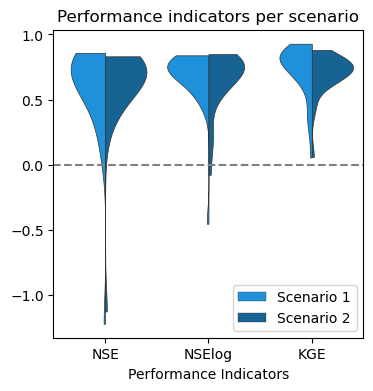

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(4,4))


data = pd.DataFrame({'NSE': pd.Series(NSE_total1 + NSE_total2), 
                     'NSElog': pd.Series(NSE_log_total1 + NSE_log_total2), 
                     'KGE': pd.Series(KGE_total1 + KGE_total2), 
                     'Scenario': ['Scenario 1'] * len(NSE_total1) + ['Scenario 2'] * len(NSE_total2)})

display(data)

sns.violinplot(x='variable', y='value', hue='Scenario', data=pd.melt(data, id_vars=['Scenario']), split=True, palette=[colors[0], colors[1]], clip=True, cut=0, trim=False, inner=None, linewidth=0.5)

plt.xlabel('Performance Indicators')
plt.ylabel('')
plt.title('Performance indicators per scenario')
plt.legend(loc='lower right')
# plt.axhline(0, color='grey', linestyle='--')


plt.savefig(f'C:/Users/Nienke Tempel/Documents/Thesis/8. Afbeeldingen/performance.pdf')


## Plot hydrograph

14.314583474784971


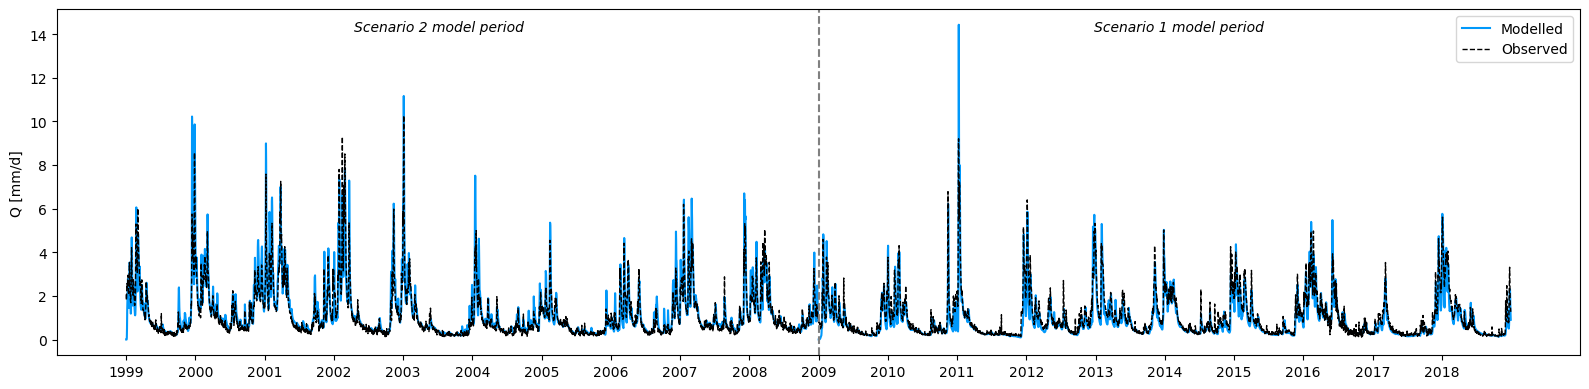

In [20]:
import matplotlib.pyplot as plt

df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 4)) # aangepaste grootte

for i in range(len(meuse_names_be_total)):
    if meuse_names_be_total[i] == "Maastricht":
        are = df_area[df_area['Station']==  meuse_names_be_total[i]]
        area = are['area_m2'].item()
        
                    
        Qobs1 = df_output_be1[f"{meuse_names_be_total[i]}"]
        Qobs2 = df_output_be2[f"{meuse_names_be_total[i]}"]
        
        Qsim1 = Q1_sim[f"{meuse_names_be_total[i]}"]
        Qsim2 = Q2_sim[f"{meuse_names_be_total[i]}"]
        
        axs.plot(df_output_be1.index, Qsim1, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs.plot(df_output_be2.index, Qsim2, linestyle='-', linewidth=1.5, color=colors[0])
        axs.plot(df_output_be2.index, Qobs2, linestyle='--', color='black', linewidth=1)
        axs.plot(df_output_be1.index, Qobs1, linestyle='--', color='black', label='Observed', linewidth=1)

        # Voeg een horizontale lijn toe op het moment van overgang tussen datasets
        axs.axvline(df_output_be2.index[-1], linestyle='--', color='grey')

        # axs.legend(loc='center right', bbox_to_anchor=(1.0, 0.8), borderaxespad=0.0)
        axs.legend(loc='upper right') # bbox_to_anchor=(1.0, 0.8), borderaxespad=0.0)
        # axs.set_title("Hydrograph Borgharen")
        
        print(max(Qsim1)-min(Qobs1))
        
        # Voeg de tekst toe
        axs.text(df_output_be2.index[1200], 14 , 'Scenario 2 model period', fontsize=10, verticalalignment='bottom', fontstyle='italic')
        axs.text(df_output_be1.index[-1] - pd.Timedelta(days=2200), 14, 'Scenario 1 model period', fontsize=10, verticalalignment='bottom', fontstyle='italic')

        # Stel de xticks in op alle eerste dagen van elk jaar
        # axs.set_xticks(pd.date_range(start=df_output_be2.index[0], end=df_output_be1.index[-1], freq='AS'))
        
        # Maak een lijst met de jaartallen tussen de start- en einddatum van de plot
        years = range(df_output_be2.index.year.min(), df_output_be1.index.year.max()+1)

        # Stel de x-ticklabels in als de jaartallen
        axs.set_xticks([pd.to_datetime(str(y)) for y in years])
        axs.set_xticklabels([str(y) for y in years])
        
        axs.set_ylabel('Q [mm/d]')


plt.tight_layout()
plt.savefig(f'C:/Users/Nienke Tempel/Documents/Thesis/8. Afbeeldingen/hydrograph.pdf')

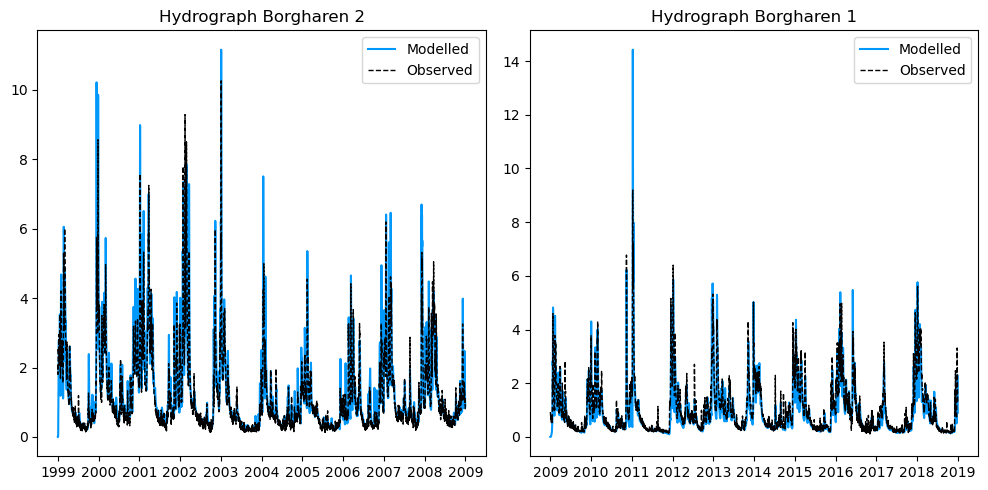

In [21]:
import matplotlib.pyplot as plt


df_output_be1 = df_output_be.loc["2009-01-01":"2018-12-31"]
df_output_be2 = df_output_be.loc["1999-01-01":"2008-12-31"]

df_output_fr1 = df_output_fr.loc["2009-01-01":"2018-12-31"]
df_output_fr2 = df_output_fr.loc["1999-01-01":"2008-12-31"]

for i in range(len(meuse_names_be_total)):
    if meuse_names_be_total[i] == "Maastricht":
        Qobs1 = df_output_be1[f"{meuse_names_be_total[i]}"]
        Qobs2 = df_output_be2[f"{meuse_names_be_total[i]}"]
        
        Qsim1 = Q1_sim[f"{meuse_names_be_total[i]}"]
        Qsim2 = Q2_sim[f"{meuse_names_be_total[i]}"]


        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # twee kolommen voor de twee plotjes

        # plotje 1
        axs[1].plot(df_output_be1.index, Qsim1, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs[1].plot(df_output_be1.index, Qobs1, linestyle='--', color='black', label='Observed', linewidth=1)
        axs[1].legend()
        axs[1].set_title("Hydrograph Borgharen 1")

        # plotje 2
        axs[0].plot(df_output_be2.index, Qsim2, linestyle='-', linewidth=1.5, color=colors[0], label='Modelled')
        axs[0].plot(df_output_be2.index, Qobs2, linestyle='--', color='black', label='Observed', linewidth=1)
        axs[0].legend()
        axs[0].set_title("Hydrograph Borgharen 2")

        plt.tight_layout()
        plt.show()
